    0 = neutral,                0 - нейтральність
    1 = anger,                  1 - злість
    2 = contempt,               2 - зневага
    3 = disgust,                3 - огида 
    4 = fear,                   4 - страх
    5 = happy,                  5 - радість 
    6 = sadness,                6 - сум 
    7 = surprise                7 - здивування 

In [114]:
import os
from shutil import copy, move

import numpy as np
import pandas as pd
import dlib
import cv2

In [115]:
emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]

if not os.listdir('sorted_data'):
    print('No emotions within sorted_data detected. Creating new')
    for em in emotions:
        os.makedirs('sorted_data/'+em)

In [60]:
encoded_emotions = {t: em for t, em in enumerate(emotions)}

In [61]:
encoded_emotions

{0: 'neutral',
 1: 'anger',
 2: 'contempt',
 3: 'disgust',
 4: 'fear',
 5: 'happy',
 6: 'sadness',
 7: 'surprise'}

Get all participants of the dataset

In [62]:
img_path = 'src_images'
annotations_path = 'src_labels'
destination = 'sorted_data'

raw_collector = []

participants = os.listdir(img_path)
labels = os.listdir(annotations_path)
# Map emotions with folder names
emo_map = dict(zip(emotions, [f'{k:03}' for k in range(7)]))

for person in sorted(labels):
    for emotion in os.listdir(os.path.join(annotations_path, person)):
        emotion_path = os.path.join(annotations_path, person, emotion)
        if os.listdir(emotion_path):
            with open(os.path.join(emotion_path, os.listdir(emotion_path)[0]), 'r') as f:
                sample = [os.listdir(emotion_path)[0], f.read()]
                raw_collector.append(sample)


In [63]:
collector = []

for filename, emotion in raw_collector:
    file_metadata = filename.split('_')
    emotion = float(emotion.replace(' ', '').replace('e+00\n', ''))
    collector.append([file_metadata, emotion])

##### Create a backup

In [65]:
with open('backup_0.csv', 'w') as f:
    f.write(str(collector).replace('.0],', '\n').replace('[', '').replace(']', ''))

#### Move images to appropriate folders

In [69]:
for [person, collection, img, ll], label in collector:
    # Such a shit :)
    assert label > 0, f'{person, collection} has neutral ({label}) label'
    
    path_to_img_folder = os.path.join(img_path, person, collection)
    
    images = sorted(os.listdir(path_to_img_folder))
    # First 20% of images are neutral. The last (suppose 50%) are emotional.
    n = len(images)
    for i, image in enumerate(images, 1):
        img_with_path = os.path.join(path_to_img_folder, image)
        # Mark first 20% of images as neutral
        if i / n <= 0.2:
            copy(img_with_path, os.path.join(destination, encoded_emotions[0], image))
        elif i / n >= 0.4:
            copy(img_with_path, os.path.join(destination, encoded_emotions[int(label)], image))
        # Mark last 50% of images as not neutral
        #print(img_with_path, label, encoded_emotions[int(label)], round(100 * i / n, 2))
    

KeyboardInterrupt: 

Now go to folders & throw out some images manually (especially from the neutral folder)



After that pass all the images through the dlib keypoint detector to get all the facial points

In [70]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('../face_landmarks.dat')


def shape_to_np(shape, dtype="int", landmarks_count=68):
    point = np.zeros((landmarks_count, 2), dtype=dtype)

    for i in range(landmarks_count):
        point[i] = (shape.part(i).x, shape.part(i).y)
    return point


def get_normalized_coords(shape, w, h):
    face_landmarks = []

    x_c, y_c = np.mean(shape, axis=0)
    for x, y in shape:
        face_landmarks.append([(x_c - x) / w, (y_c - y) / h])
    return np.array(face_landmarks)


def get_radius_vector(shape, w, h):
    rad_vec = []
    x_c, y_c = np.mean(shape, axis=0)
    for x, y in shape:
            rad_vec.append(np.sqrt(np.square((x_c - x) / w) + np.square((y_c - y) / h)))
    return rad_vec


def get_face_landmarks(img_name, img_array, predictor):
    gray_image = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
    h, w = img_array.shape[:2]
    rects = detector(gray_image, 1)
#     rad_vectors = []
#     face_landmarks = []
    for i, rect in enumerate(rects):
        if i > 1:
            print(f'{img_name} seems to fail')
            break
        face_detector = predictor(gray_image, rect)
        shape = shape_to_np(face_detector)
      
       # face_landmarks.append()
       # rad_vectors.append()
        return get_normalized_coords(shape, w, h), get_radius_vector(shape, w, h)




In [66]:
#!pip install atpbar
from atpbar import atpbar

In [71]:
jsonlike = []
for emotion in atpbar(emotions, name='images'):
    for image in atpbar(os.listdir(os.path.join(destination, emotion)), name=emotion):
        imgpath = os.path.join(destination, emotion, image)
        try:
            img_array = cv2.imread(imgpath)
            face_landmarks, rad_vectors = get_face_landmarks(image, img_array, predictor)
        except:
            print(f'failed on {imgpath}')
            continue
        
        current_image_collector = {'image': image, 'emotion': emotion}

        
        #print(face_landmarks[0])
        
        for i, [x, y] in enumerate(face_landmarks):
            current_image_collector.update({f'landmark_{i}_x':x})
            current_image_collector.update({f'landmark_{i}_y':y})
            current_image_collector.update({f'landmark_{i}_r':rad_vectors[i]})
        jsonlike.append(current_image_collector)

        
        


VBox()

failed on sorted_data/neutral/.DS_Store
failed on sorted_data/fear/S046_003_00000013.png


In [72]:
df2 = pd.DataFrame(jsonlike)

In [73]:
df2.head()

,emotion,image,landmark_0_r,landmark_0_x,landmark_0_y,landmark_10_r,landmark_10_x,landmark_10_y,landmark_11_r,landmark_11_x,...,landmark_6_y,landmark_7_r,landmark_7_x,landmark_7_y,landmark_8_r,landmark_8_x,landmark_8_y,landmark_9_r,landmark_9_x,landmark_9_y
0,neutral,S064_004_00000001.png,0.234012,0.192325,0.133313,0.228506,-0.081112,-0.213625,0.198456,-0.110800,...,-0.215666,0.257333,0.050138,-0.252401,0.262625,0.003263,-0.262605,0.258421,-0.045175,-0.254442
1,neutral,S034_003_00000004.png,0.166504,0.147151,0.077911,0.192962,-0.080974,-0.175150,0.181091,-0.109099,...,-0.177191,0.201650,0.028401,-0.199640,0.203925,-0.009099,-0.203721,0.203019,-0.046599,-0.197599
2,neutral,S071_006_00000002.png,0.202070,0.173759,0.103151,0.210949,-0.080928,-0.194808,0.198970,-0.115303,...,-0.192767,0.220670,0.048759,-0.215216,0.223406,0.003447,-0.223379,0.221254,-0.041866,-0.217257
3,neutral,S052_006_00000001.png,0.219137,0.188350,0.112005,0.245875,-0.078837,-0.232893,0.228063,-0.116337,...,-0.222689,0.255677,0.057100,-0.249220,0.259691,0.011788,-0.259424,0.257959,-0.036650,-0.255342
4,neutral,S075_008_00000001.png,0.243070,0.210271,0.121939,0.253351,-0.099104,-0.233163,0.228385,-0.135041,...,-0.235204,0.277878,0.057146,-0.271939,0.284185,0.000896,-0.284184,0.277831,-0.056916,-0.271939


In [74]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4765 entries, 0 to 4764
Columns: 206 entries, emotion to landmark_9_y
dtypes: float64(204), object(2)
memory usage: 7.5+ MB


In [75]:
df2.describe()

,landmark_0_r,landmark_0_x,landmark_0_y,landmark_10_r,landmark_10_x,landmark_10_y,landmark_11_r,landmark_11_x,landmark_11_y,landmark_12_r,...,landmark_6_y,landmark_7_r,landmark_7_x,landmark_7_y,landmark_8_r,landmark_8_x,landmark_8_y,landmark_9_r,landmark_9_x,landmark_9_y
count,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,...,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000,4765.000000
mean,0.213263,0.180787,0.111952,0.233440,-0.091717,-0.214362,0.214744,-0.126752,-0.172852,0.194798,...,-0.217074,0.251208,0.044265,-0.247117,0.255872,-0.003370,-0.255723,0.250985,-0.051129,-0.245537
std,0.021205,0.017572,0.020122,0.027265,0.011426,0.027282,0.023731,0.014116,0.023132,0.021129,...,0.027126,0.030378,0.008875,0.030384,0.031803,0.008021,0.031811,0.030390,0.009375,0.030441
min,0.155019,0.129665,0.046188,0.166177,-0.139108,-0.317279,0.151769,-0.173483,-0.278952,0.137276,...,-0.321446,0.181218,0.012914,-0.358946,0.183831,-0.041199,-0.371446,0.181003,-0.097449,-0.358946
25%,0.200726,0.171553,0.099580,0.215619,-0.098529,-0.229442,0.200278,-0.135708,-0.184934,0.182777,...,-0.232713,0.230589,0.038465,-0.265126,0.233828,-0.007422,-0.274550,0.230380,-0.056066,-0.263866
50%,0.214355,0.181733,0.112875,0.230981,-0.091751,-0.211164,0.214415,-0.127068,-0.170858,0.193981,...,-0.214001,0.247966,0.044600,-0.243848,0.252625,-0.003171,-0.252491,0.247774,-0.050758,-0.242287
75%,0.227913,0.190579,0.125660,0.248996,-0.083732,-0.196909,0.227526,-0.117119,-0.158553,0.205673,...,-0.198559,0.269234,0.050643,-0.225930,0.274657,0.001654,-0.233733,0.269195,-0.045244,-0.224850
max,0.294846,0.250735,0.179592,0.336044,-0.052160,-0.154652,0.313160,-0.077160,-0.119568,0.280231,...,-0.152971,0.363718,0.067762,-0.175420,0.371447,0.017762,-0.183583,0.364280,-0.022472,-0.178631


In [76]:
df2 = df2.sample(frac=1)

In [77]:
df2.head()

,emotion,image,landmark_0_r,landmark_0_x,landmark_0_y,landmark_10_r,landmark_10_x,landmark_10_y,landmark_11_r,landmark_11_x,...,landmark_6_y,landmark_7_r,landmark_7_x,landmark_7_y,landmark_8_r,landmark_8_x,landmark_8_y,landmark_9_r,landmark_9_x,landmark_9_y
1466,anger,S034_003_00000012.png,0.167681,0.147082,0.080522,0.188779,-0.081043,-0.170498,0.176485,-0.107606,...,-0.174580,0.199055,0.028332,-0.197029,0.201397,-0.010731,-0.201110,0.198884,-0.048231,-0.192947
3591,sadness,S131_003_00000010.png,0.210872,0.180423,0.109154,0.220230,-0.089890,-0.201050,0.204389,-0.124265,...,-0.205132,0.235326,0.041360,-0.231663,0.235809,-0.005515,-0.235744,0.235180,-0.050827,-0.229622
2928,happy,S050_006_00000015.png,0.166069,0.148621,0.074100,0.184036,-0.077941,-0.166717,0.179630,-0.112316,...,-0.170798,0.198322,0.034559,-0.195288,0.201461,-0.004504,-0.201411,0.195766,-0.042004,-0.191206
2592,fear,S502_004_00000021.png,0.242095,0.202553,0.132598,0.265839,-0.104391,-0.244485,0.253223,-0.151614,...,-0.250735,0.290449,0.049775,-0.286152,0.294490,-0.001614,-0.294485,0.285406,-0.055780,-0.279902
663,neutral,S090_006_00000002.png,0.187630,0.156135,0.104052,0.239345,-0.082927,-0.224520,0.210262,-0.115740,...,-0.228601,0.265135,0.045198,-0.261255,0.271462,0.001448,-0.271459,0.263164,-0.045427,-0.259214


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle

from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [79]:
from sklearn.svm import SVC

In [80]:
label = df2['emotion']

In [81]:
le = LabelEncoder()
y = le.fit_transform(label)

In [83]:
df2 = df2.drop(['emotion', 'image'], axis=1)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(df2, y, test_size=0.2)

In [85]:
svm = SVC(kernel='linear')

In [86]:
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [87]:
y_pred = svm.predict(X_test)

In [88]:
sum(y_pred == y_test) / len(y_test)

0.6128016789087093

In [92]:
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()

AttributeError: 'numpy.ndarray' object has no attribute 'as_matrix'

In [93]:
X_train.shape, X_test.shape

((3812, 204), (953, 204))

In [94]:

model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [95]:
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


(204,)

In [103]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [104]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
pickle.dump(model, open('xgb_model.pickle', 'wb'))

Accuracy: 90.98%


In [105]:
restored = pickle.load(open("xgb_model.pickle", "rb"))

In [98]:
#restored2 = pickle.load(open("xgb_with_rv.pickle", "rb"))

In [106]:
X_sample = X_test[-1]

### Restoring the original point coordinates

In [107]:
x_c = 100
y_c = 100
w = 200
h = 200

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


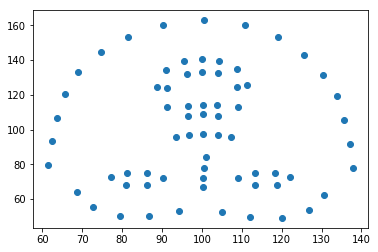

In [108]:
%time

shape = []
for k in range(0, len(X_sample), 3):
    x = x_c - w * X_sample[k+1] 
    y = y_c - h * X_sample[k+2]
    shape.append([x, y])
x_s = [s[0] for s in shape]
y_s = [s[1] for s in shape]

plt.scatter(x_s, y_s)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


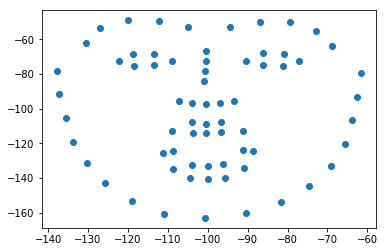

In [109]:
%time

rand_ar = np.array(X_sample).reshape(68,3)
rand_ar = np.delete(rand_ar, obj=0, axis=1)

rand_ar[:,0] = - x_c + w * rand_ar[:,0]
rand_ar[:,1] = - y_c + h * rand_ar[:,1]

plt.scatter(rand_ar[:,0], rand_ar[:,1])

In [110]:
def restore_coordinates(norm_shape, x_c, y_c, w, h):
    shape = np.array(norm_shape).reshape(68,3)
    shape = np.delete(shape, obj=0, axis=1)

    shape[:,0] = - x_c + w * rand_ar[:,0]
    shape[:,1] = - y_c + h * rand_ar[:,1]
    return shape

In [111]:
pred = model.predict(X_sample.reshape([1, 204]))

In [112]:
encoded_emotions[int(pred)]

'surprise'